# Scenario 3:  a different DEM

## Constructing DEM
Script obtained from: https://stackoverflow.com/questions/45744603/build-a-digital-elevation-model-dem-while-controlling-number-of-mountains-and

In [19]:
import numpy as np
import pandas as pd
from scipy import signal
import plotly
import plotly.graph_objs as go
import matplotlib.pyplot as plt
import matplotlib.animation as animation
plt.rcParams['font.size'] = '14'

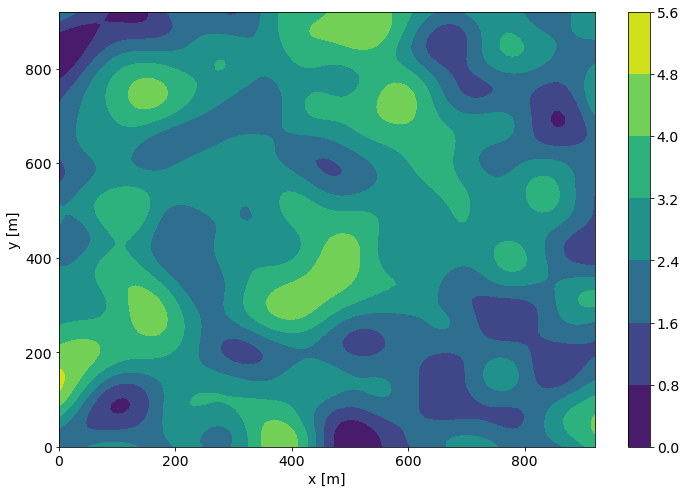

In [23]:
def rndmtx():
    """Generate random 2d-array as a digital elevation model."""

    nx = 120
    ny = 120
    dem1 = np.random.rand(nx, ny)
    # Save array to csv file befor Gaussian filter.
    # Comment the next two lines if reading from the csv file.
    #dafr = pd.DataFrame(dem1)
    #dafr.to_csv('G_dem1.csv', header=False, index=False)

    # Uncomment the next two lines to read from csv file.
    dafr = pd.read_csv('G_dem1.csv', header=None)
    dem1 = dafr.values

    # Apply the first Gaussian filter.
    sizex = 7  # The less sizex and sizey the more highlands.
    sizey = 7  # The more sizex and sizey the more water.
    x, y = np.mgrid[-sizex:sizex+1, -sizey:sizey+1]
    scale = 0.33  # The more scale the bigger the difference in elevation.
    g = np.exp(-scale*(x**2/sizex+y**2/sizey))
    filter1 = g/g.sum()  # Normalise the Gaussian function.

    dem_smooth = signal.convolve(dem1, filter1, mode='valid')
    # Rescale so it lies between 0 and 1.
    dem_smooth = 5*((dem_smooth - dem_smooth.min())
                  / (dem_smooth.max() - dem_smooth.min()))

    # Apply the second Gaussian filter to make the boundaries smoother.
    sizex = 7
    sizey = 7
    x, y = np.mgrid[-sizex:sizex+1, -sizey:sizey+1]
    g = np.exp(-0.33*(x**2/sizex+y**2/sizey))
    filter2 = g/g.sum()

    dem_smooth1 = signal.convolve(dem_smooth, filter2, mode='valid')
    dem_smooth1 = 5*((dem_smooth1 - dem_smooth1.min())
                   / (dem_smooth1.max() - dem_smooth1.min()))

    return dem_smooth1

# Get the raw random array of the digital elevation model
#   and assign it to the variable.
contour_xy = rndmtx()

# Save the array into CSV file in the working directory.
df = pd.DataFrame(contour_xy)
df.to_csv('last_data.csv', header=False, index=False)

#Option 1 for plotting (plotly)
data = [
    go.Contour(
        z=contour_xy,
        colorscale=[
            [0, 'rgb(0, 161, 233)'], [0.28, 'rgb(0, 161, 233)'],
            [0.28, 'rgb(29, 210, 108)'], [0.50, 'rgb(29, 210, 108)'],
            [0.50, 'rgb(141, 232, 130)'], [0.65, 'rgb(141, 232, 130)'],
            [0.65, 'rgb(254, 254, 152)'], [0.75, 'rgb(254, 254, 152)'],
            [0.75, 'rgb(192, 182, 122)'], [0.82, 'rgb(192, 182, 122)'],
            [0.82, 'rgb(142, 110, 92)'], [0.88, 'rgb(142, 110, 92)'],
            [0.88, 'rgb(171, 147, 142)'], [0.93, 'rgb(171, 147, 142)'],
            [0.93, 'rgb(227, 219, 217)'], [0.97, 'rgb(227, 219, 217)'],
            [0.97, 'rgb(255, 255, 255)'], [1, 'rgb(255, 255, 255)']
        ],
    ),
]

layout = go.Layout(yaxis=dict(
    autorange='reversed')) 

figure = go.Figure(data=data, layout=layout)
figure.update_yaxes(
    scaleanchor = "x",
    scaleratio = 1,
  )
figure.update_xaxes(
    range=[0,90],  # sets the range of xaxis
)
figure.show()
plotly.offline.plot(figure, filename='dem.html')

# Option 2 for plotting (matplotlib)
ny,nx = np.shape(contour_xy)
grid_imag = np.zeros((ny+2,nx+2))
grid_imag[1:-1,1:-1] = contour_xy

xs = np.arange(deltax/2,nx*deltax,deltax)
ys = np.arange(deltay/2,ny*deltay,deltay)

# Randen op zeeniveau (hoogte 0) om eiland te simuleren
grid_imag[:,0] = 0 
grid_imag[:,-1] = 0
grid_imag[0,:] = 0
grid_imag[-1,:] = 0

plt.figure(figsize= (12,8))
plt.contourf(np.flipud(contour_xy),  extent= [np.min(xs)-deltax/2, np.max(xs)+deltax/2, 
    np.min(ys)-deltay/2,np.max(ys)+deltay/2])
plt.colorbar()
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.savefig('DEM_scenario3.pdf')
plt.show()

In [13]:
print(ny)
print(nx)
xs = np.arange(deltax/2,nx*deltax,deltax)
ys = np.arange(deltay/2,ny*deltay,deltay)

92
92


array([  5.,  15.,  25.,  35.,  45.,  55.,  65.,  75.,  85.,  95., 105.,
       115., 125., 135., 145., 155., 165., 175., 185., 195., 205., 215.,
       225., 235., 245., 255., 265., 275., 285., 295., 305., 315., 325.,
       335., 345., 355., 365., 375., 385., 395., 405., 415., 425., 435.,
       445., 455., 465., 475., 485., 495., 505., 515., 525., 535., 545.,
       555., 565., 575., 585., 595., 605., 615., 625., 635., 645., 655.,
       665., 675., 685., 695., 705., 715., 725., 735., 745., 755., 765.,
       775., 785., 795., 805., 815., 825., 835., 845., 855., 865., 875.,
       885., 895., 905., 915.])

## Outflow fluxes functies
Met een Manning's coefficient van 0.03 (typisch voor kort gras).

In [3]:
def OutfluxNH2_init_eiland(NH_h, NH_d, Acell, deltax):
    '''
    Berekent de flux naar elk van de naburige cellen.
    Vorm output: array van lengte 4 (F1, F2, F4, F5).
    Benodigde inputs (volgorde 1=>5 voor buren):
    - NH_h: de hoogtes van de DEM van de NH
    - NH_d: de waterdieptes van de NH
    - Acell: oppervlakte van 1 grid cell (constant!)
    '''
    watersurface_elv = NH_h + NH_d #sommeer de twee
    watersurface_elv_sorted = np.sort(watersurface_elv)
    indices_sorted = np.argsort(watersurface_elv)
    NH_d_sorted = NH_d[indices_sorted]
    DWLs = np.zeros(len(NH_d_sorted)-1)
    for i in range(len(DWLs)):
        DWLs[i] = watersurface_elv_sorted[i+1]-watersurface_elv_sorted[i]
    
    Vc = NH_d[2]*Acell #centrale cel = derde input
    rc = np.where(indices_sorted == 2)[0]
    
    # Berekening outflow volumes
    #DeltaVis = np.zeros(5) 
    #for i in np.arange(0,int(rc)): #volgorde: van lage naar hoge water surface elevation
        #if i != rc-1: #non-adjacent cells
            #term1 = Vc-np.sum(DeltaVis)
            #term2 = DWLs[i]*(i+1)*Acell
            #DeltaVis[i]=np.min([term1,term2])
        #elif i == rc-1: #adjacent cell
            #term1 = Vc-np.sum(DeltaVis)
            #term2 = DWLs[i]*(i+1)*Acell
            #term3 = (i+1)*Acell/Acell + (i+1)*Acell*(Vc-np.sum(DeltaVis)) #GROOT!
            #DeltaVis[i]=np.min([term1,term2,term3])

    # Andere manier (oude paper):
    DWLs_old = np.zeros(len(NH_d_sorted)-1) #andere definitie van DWLs in oude paper
    for i in range(len(DWLs_old)):
        DWLs_old[i] = watersurface_elv_sorted[rc] - watersurface_elv_sorted[i]
    DeltaVis = np.zeros(5)
    for i in np.arange(0,int(rc)):
        term1 = Vc-np.sum(DeltaVis) 
        term2 = DWLs[i]*(i+1)*Acell
        term3 = (i+1)/(i+2)*(Acell*DWLs_old[i]-np.sum(DeltaVis))
        DeltaVis[i] = np.min([term1,term2,term3])
    
    # Berekening outflow fluxes
    Fluxes = np.zeros(5)
    for i in np.arange(0,int(rc)):
            for j in np.arange(i, int(rc)):
                Fluxes[i] = Fluxes[i] + DeltaVis[j]/(j+1) 
    # Fluxes toewijzen aan de juiste cellen (conventie figuur 1)
    F1 = Fluxes[indices_sorted == 0]
    F2 = Fluxes[indices_sorted == 1]
    F4 = Fluxes[indices_sorted == 3]
    F5 = Fluxes[indices_sorted == 4]

    Fout = np.hstack([F1,F2,F4,F5])
    
    # Fysisch gelimiteerde snelheden (v's) berekenen en maximum opslaan
    v_list = []
    WL_C = watersurface_elv[2] #central cell = derde input
    d = NH_d[2] #water depth (in central cell?)
    R = d
    n = 0.03 #Manning's coefficient voor kort gras!
    g = 9.81
    for i in range(len(Fout)):
        if Fout[i] != 0:
            if i < 2: #cellen rechts, boven hebben indices 0,1
                WL_N = watersurface_elv[i]
            elif i > 1: #cellen onder, links hebben indices 3,4
                WL_N = watersurface_elv[i+1]
            S = (WL_C-WL_N)/deltax #geen onderscheid deltax/deltay voor vierkante cellen!
            v_Mannings = (1/n)*(R**(2/3))*(S**(1/2))
            v_critical = np.sqrt(g*d)
            v = np.min([v_Mannings, v_critical])
            v_list.append(v)
    if len(v_list)==0: #np.max kan niet toegepast worden op een lege lijst
        vmax_NH = 0
    else:
        vmax_NH = np.max(v_list)
            
    return Fout, vmax_NH

In [4]:
def OutfluxNH2_init_eiland_randen(j,i, NH_h, NH_d, Acell, deltax):
    '''
    Berekent de flux naar elk van de naburige cellen.
    Vorm output: array van lengte 4 (F1, F2, F4, F5).
    Benodigde inputs (volgorde 1=>5 voor buren):
    - NH_h: de hoogtes van de DEM van de NH
    - NH_d: de waterdieptes van de NH
    - Acell: oppervlakte van 1 grid cell (constant!)
    '''
    if j==1:
        if NH_h[1]<NH_h[2]: #stijgende topografie aan rand
            NH_h[3]=10 #geen uitstroom naar zee
    elif j == ny:
        if NH_h[3]<NH_h[2]:
            NH_h[1]=10
    if i == 1:
        if NH_h[0]<NH_h[2]:
            NH_h[4]=10
    elif i == nx:
        if NH_h[4]<NH_h[2]:
            NH_h[0]=10
    
    watersurface_elv = NH_h + NH_d #sommeer de twee
    watersurface_elv_sorted = np.sort(watersurface_elv)
    indices_sorted = np.argsort(watersurface_elv)
    NH_d_sorted = NH_d[indices_sorted]
    DWLs = np.zeros(len(NH_d_sorted)-1)
    for i in range(len(DWLs)):
        DWLs[i] = watersurface_elv_sorted[i+1]-watersurface_elv_sorted[i]
    
    Vc = NH_d[2]*Acell #centrale cel = derde input
    rc = np.where(indices_sorted == 2)[0]
    
    # Berekening outflow volumes
    #DeltaVis = np.zeros(5) 
    #for i in np.arange(0,int(rc)): #volgorde: van lage naar hoge water surface elevation
        #if i != rc-1: #non-adjacent cells
            #term1 = Vc-np.sum(DeltaVis)
            #term2 = DWLs[i]*(i+1)*Acell
            #DeltaVis[i]=np.min([term1,term2])
        #elif i == rc-1: #adjacent cell
            #term1 = Vc-np.sum(DeltaVis)
            #term2 = DWLs[i]*(i+1)*Acell
            #term3 = (i+1)*Acell/Acell + (i+1)*Acell*(Vc-np.sum(DeltaVis)) #GROOT!
            #DeltaVis[i]=np.min([term1,term2,term3])

    # Andere manier (oude paper):
    DWLs_old = np.zeros(len(NH_d_sorted)-1) #andere definitie van DWLs in oude paper
    for i in range(len(DWLs_old)):
        DWLs_old[i] = watersurface_elv_sorted[rc] - watersurface_elv_sorted[i]
    DeltaVis = np.zeros(5)
    for i in np.arange(0,int(rc)):
        term1 = Vc-np.sum(DeltaVis) 
        term2 = DWLs[i]*(i+1)*Acell
        term3 = (i+1)/(i+2)*(Acell*DWLs_old[i]-np.sum(DeltaVis))
        DeltaVis[i] = np.min([term1,term2,term3])
    
    # Berekening outflow fluxes
    Fluxes = np.zeros(5)
    for i in np.arange(0,int(rc)):
            for j in np.arange(i, int(rc)):
                Fluxes[i] = Fluxes[i] + DeltaVis[j]/(j+1) 
    # Fluxes toewijzen aan de juiste cellen (conventie figuur 1)
    F1 = Fluxes[indices_sorted == 0]
    F2 = Fluxes[indices_sorted == 1]
    F4 = Fluxes[indices_sorted == 3]
    F5 = Fluxes[indices_sorted == 4]

    Fout = np.hstack([F1,F2,F4,F5])
    
    # Fysisch gelimiteerde snelheden (v's) berekenen en maximum opslaan
    v_list = []
    WL_C = watersurface_elv[2] #central cell = derde input
    d = NH_d[2] #water depth (in central cell?)
    R = d
    n = 0.03 #Manning's coefficient voor kort gras!
    g = 9.81
    for i in range(len(Fout)):
        if Fout[i] != 0:
            if i < 2: #cellen rechts, boven hebben indices 0,1
                WL_N = watersurface_elv[i]
            elif i > 1: #cellen onder, links hebben indices 3,4
                WL_N = watersurface_elv[i+1]
            S = (WL_C-WL_N)/deltax #geen onderscheid deltax/deltay voor vierkante cellen!
            v_Mannings = (1/n)*(R**(2/3))*(S**(1/2))
            v_critical = np.sqrt(g*d)
            v = np.min([v_Mannings, v_critical])
            v_list.append(v)
    if len(v_list)==0: #np.max kan niet toegepast worden op een lege lijst
        vmax_NH = 0
    else:
        vmax_NH = np.max(v_list)
            
    return Fout, vmax_NH

In [5]:
def OutfluxNH2_eiland(NH_h, NH_d, Acell, deltat, deltax):
    '''
    Berekent de flux naar elk van de naburige cellen.
    Vorm output: array van lengte 4 (F1, F2, F4, F5).
    Benodigde inputs (volgorde 1=>5 voor buren):
    - NH_h: de hoogtes van de DEM van de NH
    - NH_d: de waterdieptes van de NH
    - Acell: oppervlakte van 1 grid cell (constant!)
    - deltat: berekent in de vorige time loop
    '''
    
    watersurface_elv = NH_h + NH_d #sommeer de twee
    watersurface_elv_sorted = np.sort(watersurface_elv)
    indices_sorted = np.argsort(watersurface_elv)
    NH_d_sorted = NH_d[indices_sorted]
    DWLs = np.zeros(len(NH_d_sorted)-1)
    for i in range(len(DWLs)):
        DWLs[i] = watersurface_elv_sorted[i+1]-watersurface_elv_sorted[i]
    
    Vc = NH_d[2]*Acell #centrale cel = derde input
    rc = np.where(indices_sorted == 2)[0]
    
    # Berekening outflow volumes
    #DeltaVis = np.zeros(5) 
    #for i in np.arange(0,int(rc)): #volgorde: van lage naar hoge water surface elevation
        #if i != rc-1: #non-adjacent cells
            #term1 = Vc-np.sum(DeltaVis)
            #term2 = DWLs[i]*(i+1)*Acell
            #DeltaVis[i]=np.min([term1,term2])
        #elif i == rc-1: #adjacent cell
            #term1 = Vc-np.sum(DeltaVis)
            #term2 = DWLs[i]*(i+1)*Acell
            #term3 = (i+1)*Acell/Acell + (i+1)*Acell*(Vc-np.sum(DeltaVis)) #GROOT!
            #DeltaVis[i]=np.min([term1,term2,term3])

    # Andere manier (oude paper):
    DWLs_old = np.zeros(len(NH_d_sorted)-1) #andere definitie van DWLs in oude paper
    for i in range(len(DWLs_old)):
        DWLs_old[i] = watersurface_elv_sorted[rc] - watersurface_elv_sorted[i]
    DeltaVis = np.zeros(5)
    for i in np.arange(0,int(rc)):
        term1 = Vc-np.sum(DeltaVis) 
        term2 = DWLs[i]*(i+1)*Acell
        term3 = (i+1)/(i+2)*(Acell*DWLs_old[i]-np.sum(DeltaVis))
        DeltaVis[i] = np.min([term1,term2,term3])
    
    # Berekening outflow fluxes
    Fluxes = np.zeros(5)
    for i in np.arange(0,int(rc)):
            for j in np.arange(i, int(rc)):
                Fluxes[i] = Fluxes[i] + DeltaVis[j]/(j+1) 
    # Fluxes toewijzen aan de juiste cellen (conventie figuur 1)
    F1 = Fluxes[indices_sorted == 0]
    F2 = Fluxes[indices_sorted == 1]
    F4 = Fluxes[indices_sorted == 3]
    F5 = Fluxes[indices_sorted == 4]

    Fout = np.hstack([F1,F2,F4,F5])
    
    # Flux correction
    vj_list = []
    WL_C = watersurface_elv[2] #central cell = derde input
    z_C = NH_h[2]
    d = NH_d[2] #water depth (in central cell?)
    R = d
    n = 0.03 #Manning's coefficient voor kort gras!
    g = 9.81
    for i in range(len(Fout)):
        if Fout[i] != 0:
            if i < 2: #cellen rechts, boven hebben indices 0,1
                WL_N = watersurface_elv[i]
                z_N = NH_h[i]
            elif i > 1: #cellen onder, links hebben indices 3,4
                WL_N = watersurface_elv[i+1]
                z_N = NH_h[i+1]
            # Calculate vstar
            dstar = np.max([WL_C,WL_N])-np.max([z_C,z_N])
            if dstar != 0:
                vstar = Fout[i]/(dstar*deltax*deltat)
            elif dstar == 0: #deling door 0 voorkomen
                vstar = 0
            # Calculate v
            S = (WL_C-WL_N)/deltax #geen onderscheid deltax/deltay voor vierkante cellen!
            v_Mannings = (1/n)*(R**(2/3))*(S**(1/2))
            v_critical = np.sqrt(g*d)
            v = np.min([v_Mannings, v_critical])
            # Flux recalculation if necessary
            if vstar > v:
                vj_list.append(v)
                Fout[i] = v*dstar*deltax*deltat
            else:
                vj_list.append(v) #AANPASSING: ENKEL WERKEN MET DE THEORERTISCHE MAX SNELHEID
    if len(vj_list)==0: #np.max kan niet toegepast worden op een lege lijst
        vjmax_NH = 0
    else:
        vjmax_NH = np.nanmax(vj_list) #np.nanmax om NaN waarden te negeren
    
    return Fout, vjmax_NH

In [6]:
def OutfluxNH2_eiland_randen(j,i, NH_h, NH_d, Acell, deltat, deltax):
    '''
    Berekent de flux naar elk van de naburige cellen.
    Vorm output: array van lengte 4 (F1, F2, F4, F5).
    Benodigde inputs (volgorde 1=>5 voor buren):
    - NH_h: de hoogtes van de DEM van de NH
    - NH_d: de waterdieptes van de NH
    - Acell: oppervlakte van 1 grid cell (constant!)
    - deltat: berekent in de vorige time loop
    '''
    if j==1:
        if NH_h[1]<NH_h[2]: #stijgende topografie aan rand
            NH_h[3]=10 #geen uitstroom naar zee
    elif j == ny:
        if NH_h[3]<NH_h[2]:
            NH_h[1]=10
    if i == 1:
        if NH_h[0]<NH_h[2]:
            NH_h[4]=10
    elif i == nx:
        if NH_h[4]<NH_h[2]:
            NH_h[0]=10
    
    watersurface_elv = NH_h + NH_d #sommeer de twee
    watersurface_elv_sorted = np.sort(watersurface_elv)
    indices_sorted = np.argsort(watersurface_elv)
    NH_d_sorted = NH_d[indices_sorted]
    DWLs = np.zeros(len(NH_d_sorted)-1)
    for i in range(len(DWLs)):
        DWLs[i] = watersurface_elv_sorted[i+1]-watersurface_elv_sorted[i]
    
    Vc = NH_d[2]*Acell #centrale cel = derde input
    rc = np.where(indices_sorted == 2)[0]
    
    # Berekening outflow volumes
    #DeltaVis = np.zeros(5) 
    #for i in np.arange(0,int(rc)): #volgorde: van lage naar hoge water surface elevation
        #if i != rc-1: #non-adjacent cells
            #term1 = Vc-np.sum(DeltaVis)
            #term2 = DWLs[i]*(i+1)*Acell
            #DeltaVis[i]=np.min([term1,term2])
        #elif i == rc-1: #adjacent cell
            #term1 = Vc-np.sum(DeltaVis)
            #term2 = DWLs[i]*(i+1)*Acell
            #term3 = (i+1)*Acell/Acell + (i+1)*Acell*(Vc-np.sum(DeltaVis)) #GROOT!
            #DeltaVis[i]=np.min([term1,term2,term3])

    # Andere manier (oude paper):
    DWLs_old = np.zeros(len(NH_d_sorted)-1) #andere definitie van DWLs in oude paper
    for i in range(len(DWLs_old)):
        DWLs_old[i] = watersurface_elv_sorted[rc] - watersurface_elv_sorted[i]
    DeltaVis = np.zeros(5)
    for i in np.arange(0,int(rc)):
        term1 = Vc-np.sum(DeltaVis) 
        term2 = DWLs[i]*(i+1)*Acell
        term3 = (i+1)/(i+2)*(Acell*DWLs_old[i]-np.sum(DeltaVis))
        DeltaVis[i] = np.min([term1,term2,term3])
    
    # Berekening outflow fluxes
    Fluxes = np.zeros(5)
    for i in np.arange(0,int(rc)):
            for j in np.arange(i, int(rc)):
                Fluxes[i] = Fluxes[i] + DeltaVis[j]/(j+1) 
    # Fluxes toewijzen aan de juiste cellen (conventie figuur 1)
    F1 = Fluxes[indices_sorted == 0]
    F2 = Fluxes[indices_sorted == 1]
    F4 = Fluxes[indices_sorted == 3]
    F5 = Fluxes[indices_sorted == 4]

    Fout = np.hstack([F1,F2,F4,F5])
    
    # Flux correction
    vj_list = []
    WL_C = watersurface_elv[2] #central cell = derde input
    z_C = NH_h[2]
    d = NH_d[2] #water depth (in central cell?)
    R = d
    n = 0.03 #Manning's coefficient voor kort gras!
    g = 9.81
    for i in range(len(Fout)):
        if Fout[i] != 0:
            if i < 2: #cellen rechts, boven hebben indices 0,1
                WL_N = watersurface_elv[i]
                z_N = NH_h[i]
            elif i > 1: #cellen onder, links hebben indices 3,4
                WL_N = watersurface_elv[i+1]
                z_N = NH_h[i+1]
            # Calculate vstar
            dstar = np.max([WL_C,WL_N])-np.max([z_C,z_N])
            if dstar != 0:
                vstar = Fout[i]/(dstar*deltax*deltat)
            elif dstar == 0: #deling door 0 voorkomen
                vstar = 0
            # Calculate v
            S = (WL_C-WL_N)/deltax #geen onderscheid deltax/deltay voor vierkante cellen!
            v_Mannings = (1/n)*(R**(2/3))*(S**(1/2))
            v_critical = np.sqrt(g*d)
            v = np.min([v_Mannings, v_critical])
            # Flux recalculation if necessary
            if vstar > v:
                vj_list.append(v)
                Fout[i] = v*dstar*deltax*deltat
            else:
                vj_list.append(v) #AANPASSING: ENKEL WERKEN MET DE THEORERTISCHE MAX SNELHEID
    if len(vj_list)==0: #np.max kan niet toegepast worden op een lege lijst
        vjmax_NH = 0
    else:
        vjmax_NH = np.nanmax(vj_list) #np.nanmax om NaN waarden te negeren
    
    return Fout, vjmax_NH

## Time loop

In [7]:
# Parameters definiëren
deltax = 10 #m
deltay = 10 #m
Acell = deltax*deltay
tend = 60*150
rain = 20/(1000*3600) #regenval in m/s
duration = 3600 
theta = 0.7 #relaxatieparameter (gekalibreerd)

# Initialisatie
deltat = 1*60
depths_imag = np.zeros((ny+2,nx+2))
depths_imag[1:-1,1:-1] = rain*deltat #waterdiepte na 1 min regenval aan 20 mm/h
t_list = [] #lijst met tijdstappen
t = deltat
t_list.append(t)
depths_list = [] #lijst met waterdieptes voor alle tijdstap
depths_list.append(depths_imag)


##1## Eerste iteratie in de tijd => functie OutfluxNH2_init
fluxes_imag = np.zeros((5,ny+2,nx+2)) #elke cell ontvangt 5 fluxen: 4 positieve en 1 negatieve (!)
depths_imag = depths_list[-1]
depths_imag_new = np.zeros((ny+2,nx+2)) #of np.copy(depths_imag)
vmax_list = []
for j in np.arange(1,ny+1):
    for i in np.arange(1,nx+1):
        # Hoogtes in neighbourhood
        hneigb1 = grid_imag[j,i+1]
        hneigb2 = grid_imag[j+1,i]
        hneigb3 = grid_imag[j,i]
        hneigb4 = grid_imag[j-1,i]
        hneigb5 = grid_imag[j,i-1]
        NH_h = np.hstack([hneigb1,hneigb2,hneigb3,hneigb4,hneigb5])
        # Waterdieptes in neighbourhood
        dneigb1 = depths_imag[j,i+1]
        dneigb2 = depths_imag[j+1,i]
        dneigb3 = depths_imag[j,i]
        dneigb4 = depths_imag[j-1,i]
        dneigb5 = depths_imag[j,i-1]
        NH_d = np.hstack([dneigb1,dneigb2,dneigb3,dneigb4,dneigb5])
        # Outflow fluxes berekenen
        if j==1 or j==ny or i==1 or i==nx:
            F, vmax_NH = OutfluxNH2_init_eiland_randen(j,i, NH_h, NH_d, Acell, deltax)
        else:
            F, vmax_NH = OutfluxNH2_init_eiland(NH_h, NH_d, Acell, deltax)
        F1 = F[0]
        F2 = F[1]
        F4 = F[2]
        F5 = F[3]
        # Toekennen van totale outflow flux centrale cel (!)
        F3 = -F1-F2-F4-F5 
        fluxes_imag[2,j,i] = F3
        # Toekennen van inflow fluxes naburige cellen
        fluxes_imag[3,j,i+1] = F1
        fluxes_imag[4,j+1,i] = F2
        fluxes_imag[0,j-1,i] = F4
        fluxes_imag[1,j,i-1] = F5
        # vmax_NH opslaan in lijst
        vmax_list.append(vmax_NH)
    
# Globale tijdstap updaten
deltat = deltax/np.nanmax(vmax_list[:]) #np.nanmax om NaN waarden te negeren
print(deltat)
t = t + deltat
t_list.append(t)
    
depths_imag_new = np.copy(depths_imag) + theta*np.sum(fluxes_imag,axis=0)/Acell
# Waterhoogtestijging in de zee is verwaarloosbaar 
depths_imag_new[:,0] = 0 
depths_imag_new[:,-1] = 0
depths_imag_new[0,:] = 0
depths_imag_new[-1,:] = 0

# Regenval toevoegen aan waterdiepte
if t < duration: #alleen in het eerste uur
    depths_imag_new[1:-1,1:-1] = depths_imag_new[1:-1,1:-1] + rain*deltat
elif t > duration and (t-deltat) < duration:
    depths_imag_new[1:-1,1:-1] = depths_imag_new[1:-1,1:-1] + rain*(duration-(t-deltat))
depths_list.append(depths_imag_new)


##2## Overige iteraties in de tijd => functie OutfluxNH2
while t < tend:
    fluxes_imag = np.zeros((5,ny+2,nx+2)) #elke cell ontvangt 5 fluxen: 4 positieve en 1 negatieve (!)
    depths_imag = depths_list[-1]
    depths_imag_new = np.zeros((ny+2,nx+2)) #of np.copy(depths_imag)
    vjmax_list = []
    for j in np.arange(1,ny+1):
        for i in np.arange(1,nx+1):
            # Hoogtes in neighbourhood
            hneigb1 = grid_imag[j,i+1]
            hneigb2 = grid_imag[j+1,i]
            hneigb3 = grid_imag[j,i]
            hneigb4 = grid_imag[j-1,i]
            hneigb5 = grid_imag[j,i-1]
            NH_h = np.hstack([hneigb1,hneigb2,hneigb3,hneigb4,hneigb5])
            # Waterdieptes in neighbourhood
            dneigb1 = depths_imag[j,i+1]
            dneigb2 = depths_imag[j+1,i]
            dneigb3 = depths_imag[j,i]
            dneigb4 = depths_imag[j-1,i]
            dneigb5 = depths_imag[j,i-1]
            NH_d = np.hstack([dneigb1,dneigb2,dneigb3,dneigb4,dneigb5])
            # Outflow fluxes berekenen
            if j==1 or j==ny or i==1 or i==nx:
                F, vjmax_NH = OutfluxNH2_eiland_randen(j,i, NH_h, NH_d, Acell, deltat, deltax) #!
            else:
                F, vjmax_NH = OutfluxNH2_eiland(NH_h, NH_d, Acell, deltat, deltax)
            F1 = F[0]
            F2 = F[1]
            F4 = F[2]
            F5 = F[3]
            # Toekennen van totale outflow flux centrale cel (!)
            F3 = -F1-F2-F4-F5 
            fluxes_imag[2,j,i] = F3
            # Toekennen van inflow fluxes naburige cellen
            fluxes_imag[3,j,i+1] = F1
            fluxes_imag[4,j+1,i] = F2
            fluxes_imag[0,j-1,i] = F4
            fluxes_imag[1,j,i-1] = F5
            # vmax_NH opslaan in lijst
            vjmax_list.append(vjmax_NH)
      
    # Globale tijdstap updaten
    #if not(np.isnan(np.max(vjmax_list))): #corrigeren voor NaN
        #deltat = deltax/np.max(vjmax_list) 
    #else:
        #print('Probleem met NaN')
    deltat = deltax/np.nanmax(vjmax_list) #np.nanmax om NaN waarden te negeren
    print(deltat)
    t = t + deltat
    t_list.append(t)
            
    depths_imag_new = np.copy(depths_imag) + theta*np.sum(fluxes_imag,axis=0)/Acell
    # Waterhoogtestijging in de zee is verwaarloosbaar 
    depths_imag_new[:,0] = 0 
    depths_imag_new[:,-1] = 0
    depths_imag_new[0,:] = 0
    depths_imag_new[-1,:] = 0

    # Regenval toevoegen aan waterdiepte
    if t < duration: #alleen in het eerste uur
        depths_imag_new[1:-1,1:-1] = depths_imag_new[1:-1,1:-1] + rain*deltat
    elif t > duration and (t-deltat) < duration:
        depths_imag_new[1:-1,1:-1] = depths_imag_new[1:-1,1:-1] + rain*(duration-(t-deltat))
    depths_list.append(depths_imag_new)

174.87435419566722
81.40674377872453
72.65576774819449
61.03143360855781
50.01486754436087
42.93748037125417


C:\Users\olivi\AppData\Local\Temp/ipykernel_7116/1211989900.py:96: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\olivi\AppData\Local\Temp/ipykernel_7116/1211989900.py:97: RuntimeWarning:

invalid value encountered in sqrt

C:\Users\olivi\AppData\Local\Temp/ipykernel_7116/1211989900.py:108: RuntimeWarning:

All-NaN axis encountered



38.107126426695544
36.360314874198636
34.04177032674564
32.21562889007736
32.98220037224415
33.33725442761325


C:\Users\olivi\AppData\Local\Temp/ipykernel_7116/1151600139.py:84: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\olivi\AppData\Local\Temp/ipykernel_7116/1151600139.py:85: RuntimeWarning:

invalid value encountered in sqrt

C:\Users\olivi\AppData\Local\Temp/ipykernel_7116/1151600139.py:96: RuntimeWarning:

All-NaN axis encountered



33.17037765209147
32.465854610306074
30.509277468167625
28.8973307259668
27.932385323678762
27.01962273095021
26.182560862874077
25.558191246044885
25.19267811554805
24.901054528103824
24.621397311515647
24.413149323043942
24.232328683980032
24.10037036610496
23.9902587494496
23.883926230568207
23.783036083442504
23.6869722230683
23.597211333832753
23.514021233402396
23.43771516980371
23.36783252580338
23.304217413122785
23.246358209580357
23.193689297401512
23.14571151144267
23.101944540964855
23.061966317350876
23.025404411594202
22.991937774290452
22.96128428033057
22.933198811438505
22.90746353978235
22.883884569464414
22.862287822612124
22.842515105578773
22.824421367267462
22.807872586938114
22.792744364088342
22.778920926485068
22.76629453527993
22.75476505626419
22.74423966588257
22.73463257503076
22.725864736684244
22.717863520027585
22.7105623472141
22.703900301264767
22.697821717287713
22.69227577114144
22.687216076923786
22.682600302848442
22.678389811425287
22.674549327435

## Visualisation

Animatie:

.....................Gif opgeslaan als eiland_randencorr_verslag_150min


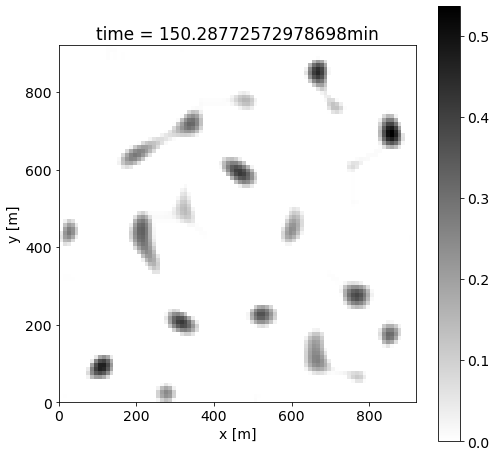

In [20]:
# Gif functie zonder flipud
def gif_maken_bis(layers, tijdstappen, fps, naam_file):
    fig, ax = plt.subplots(figsize = (8,8))
    a = layers[0]
    im = plt.imshow(a, interpolation='none', vmin=0, vmax=np.max(layers[:]), cmap = 'binary', 
    extent= [np.min(xs)-deltax/2, np.max(xs)+deltax/2, 
    np.min(ys)-deltay/2,np.max(ys)+deltay/2]) #zonder flipud() om overeenkomst met dem.html te verkrijgen
    plt.colorbar(im)
    plt.xlabel('x [m]')
    plt.ylabel('y [m]')


    def animate_func(i):
        if i % fps == 0:
            print( '.', end ='' )

        im.set_array(layers[i]) #zonder flipud()
        ax.set_title('time = '+str(tijdstappen[i]/60) + 'min')
    
        return [im]

    anim = animation.FuncAnimation(fig, animate_func, frames = len(layers), interval = 1000 / fps) # in ms)
    anim.save(naam_file+'.gif', writer= 'pillow', fps=fps)# extra_args=['-vcodec', 'libx264'])        
    print("Gif opgeslaan als "+naam_file)
    
# Randen verwijderen
depths_list_bis = [] 
for i in range(len(depths_list)):
    bisframe = depths_list[i][1:-1,1:-1]
    depths_list_bis.append(bisframe)

# Gif maken
gif_maken_bis(depths_list_bis, t_list, 20, 'eiland_randencorr_verslag_150min')

Figuur die het verloop van de waterdiepte in de tijd weergeeft voor een willekeurige helling en vallei in het heuvellandschap:

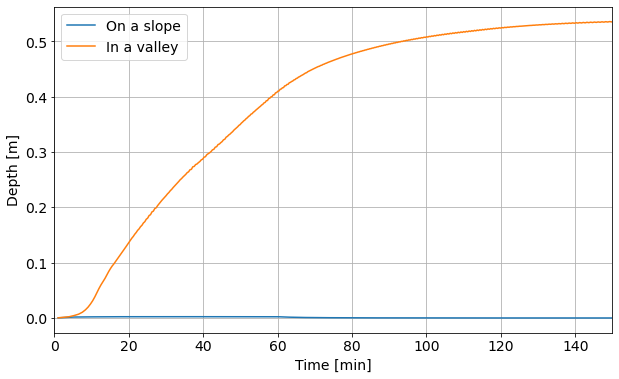

In [49]:
t_min_list = []
depths_slope_list = []
depths_valley_list = []
for i in range(len(t_list)):
    t_min_list.append(t_list[i]/60) #omgezet naar minuten
    depth_slope = depths_list_bis[i][6,56] #waterdiepte op een helling
    depths_slope_list.append(depth_slope)
    depth_valley = depths_list_bis[i][22,85] #waterdiepte in een vallei. was 5,71 initieel
    depths_valley_list.append(depth_valley)

plt.figure(figsize = (10,6))
plt.grid(b=True)
plt.plot(t_min_list, depths_slope_list, label = 'On a slope')
plt.plot(t_min_list, depths_valley_list, label = 'In a valley')
plt.xlim((0, 150))
plt.xlabel('Time [min]')
plt.ylabel('Depth [m]')
#plt.title(r'Water depth on a slope and in a valley')
plt.legend()
#plt.savefig('eiland_slope_valley.png', dpi=1000)
plt.savefig('eiland_slope_valley.pdf')

Figuur die het grid plot op twee interessante tijdstippen: bijv. na 30 en 90 min.

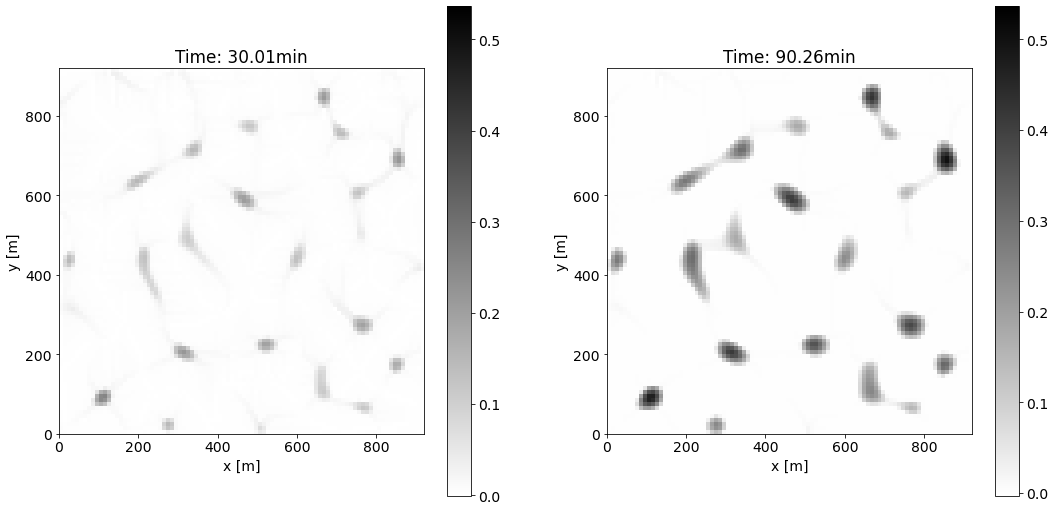

In [24]:
times_interest = [30*60,90*60]
locs = []
for i in range(len(times_interest)):
    locations = np.where(np.array(t_list) > times_interest[i])
    locs.append(locations[0][0])

max_depth = np.max(depths_list_bis[:])

plt.figure(figsize = (18,9))
for i in range(len(locs)):
    plt.subplot(1,2,i+1)
    hoogtes = depths_list_bis[locs[i]]
    plt.imshow(hoogtes, vmax = max_depth, cmap = 'binary', extent= [np.min(xs)-deltax/2, np.max(xs)+deltax/2, 
    np.min(ys)-deltay/2,np.max(ys)+deltay/2])
    plt.colorbar()
    plt.xlabel('x [m]')
    plt.ylabel('y [m]')
    plt.title('Time: '+ str(np.round(t_list[locs[i]]/60,2)) + 'min')
    #plt.savefig("eiland_30min_90min.png", dpi=1200)
    plt.savefig('eiland_30min_90min.pdf')

In [48]:
yloc, xloc = np.where(depths_list_bis[-1] == np.max(depths_list_bis[-1]))
print(yloc)
print(xloc)
print(ys[-1] - 22*deltay)
print(deltax/2 + xloc*deltax)
print(ys)

[22]
[85]
695.0
[855.]
[  5.  15.  25.  35.  45.  55.  65.  75.  85.  95. 105. 115. 125. 135.
 145. 155. 165. 175. 185. 195. 205. 215. 225. 235. 245. 255. 265. 275.
 285. 295. 305. 315. 325. 335. 345. 355. 365. 375. 385. 395. 405. 415.
 425. 435. 445. 455. 465. 475. 485. 495. 505. 515. 525. 535. 545. 555.
 565. 575. 585. 595. 605. 615. 625. 635. 645. 655. 665. 675. 685. 695.
 705. 715. 725. 735. 745. 755. 765. 775. 785. 795. 805. 815. 825. 835.
 845. 855. 865. 875. 885. 895. 905. 915.]
